In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import lightgbm
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
dir = "/Users/Watanatornpitakp/Desktop/Columbia/DataOpen/"

In [3]:
odds_df = pd.read_csv(dir + "Code/EDA/stacked_df.csv")

odds_df["B365_bookspread"] = np.where(odds_df["B365_bookspread"]==0,
                                      -1*odds_df["B365_bookspread"],
                                      odds_df["B365_bookspread"])

odds_df =  odds_df[["match_id", "team_id", "B365_bookspread"]]

In [4]:
match_df = pd.read_csv(dir + "Data/match_clean.csv")

match_df = match_df.drop('Unnamed: 0',axis=1)

In [5]:
odds_col = match_df.columns[32:63].tolist()

odds_df = match_df[["date", "match_id", "home_team_id", "away_team_id"]]

for i in range(0, len(odds_col), 3):
    print(odds_col[i:i+3])
    
    cur_odds_df = match_df.loc[~match_df[odds_col[i]].isnull(), 
                               ["date", "match_id", "home_team_id"] + odds_col[i:i+3]]
    
    inv_odds = (1/cur_odds_df[odds_col[i:i+3]])

    booksum = inv_odds.sum(axis=1)

    margin = booksum - 1

    inv_odds["booksum"] = booksum

    bookprob = pd.concat([inv_odds[odds_col[i]]/inv_odds["booksum"], 
                          inv_odds[odds_col[i+1]]/inv_odds["booksum"], 
                          inv_odds[odds_col[i+2]]/inv_odds["booksum"]], axis=1)

    bookprob.columns = odds_col[i:i+3]
    
    bookprob["{}_bookspread".format(odds_col[i][:-1])] = bookprob[odds_col[i]] - bookprob[odds_col[i+2]]
    
    bookprob["{}_margin".format(odds_col[i][:-1])] = margin
    
    bookprob[["date", "match_id", "home_team_id"]] = cur_odds_df[["date", "match_id", "home_team_id"]]
    
    odds_df = odds_df.merge(bookprob, 
                            on=["date", "match_id", "home_team_id"],
                            how="left")

['B365H', 'B365D', 'B365A']
['BWH', 'BWD', 'BWA']
['IWH', 'IWD', 'IWA']
['LBH', 'LBD', 'LBA']
['PSH', 'PSD', 'PSA']
['WHH', 'WHD', 'WHA']
['SJH', 'SJD', 'SJA']
['VCH', 'VCD', 'VCA']
['GBH', 'GBD', 'GBA']
['BSH', 'BSD', 'BSA']


In [6]:
wl_odds_player_df = pd.read_csv(dir + "Data/wl_odds_player_df.csv")

wl_odds_player_df = wl_odds_player_df.drop('Unnamed: 0', axis=1)

odds_df = odds_df.loc[odds_df["match_id"].isin(set(wl_odds_player_df["match_id"]))]

In [7]:
home_df = odds_df[["match_id", "home_team_id", "B365_bookspread"]]
home_df.columns = ["match_id", "team_id", "B365_bookspread"]

away_df = odds_df[["match_id", "away_team_id", "B365_bookspread"]]
away_df.columns = ["match_id", "team_id", "B365_bookspread"]
away_df["B365_bookspread"] = -1*away_df["B365_bookspread"]

odds_df = pd.concat([home_df, away_df])

<ipython-input-7-10b0c71b543d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_df["B365_bookspread"] = -1*away_df["B365_bookspread"]


In [8]:
seasons = sorted(wl_odds_player_df["season"].unique())

i=4
seasons[i:i+4][:-1], seasons[i:i+4][-1]

(['2012/2013', '2013/2014', '2014/2015'], '2015/2016')

In [9]:
i = 3
    
train_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin(seasons[i:i+4][:-1])].dropna()
test_df = wl_odds_player_df.loc[wl_odds_player_df["season"].isin([seasons[i:i+4][-1]])].dropna()

train_dates = sorted(train_df["date"].unique())

calib_dates = random.sample(train_dates, int(len(train_dates)*0.25))

calib_df = train_df.loc[train_df["date"].isin(calib_dates)]

train_df = train_df.loc[~train_df["date"].isin(calib_dates)]

feat_col = [c for c in train_df.columns if "avg" in c]
feat_col = feat_col + ["rating_diff"]

skf = StratifiedKFold(n_splits=6, shuffle=True)

lgb_param_grid = {'lgb__n_estimators': [100, 200, 300,],
                 'lgb__num_leaves':  [2, 4, 6, 10, 15, 20],
                 'lgb__subsample': [0.4, 0.6, 0.8, 1],
                 'lgb__colsample_bytree': [0.4, 0.6, 0.8, 1],
                 'lgb__is_unbalance': [False]}

lgb_pipe = Pipeline([("lgb", lightgbm.LGBMClassifier())])

#lose
lgb_cv_lose = RandomizedSearchCV(lgb_pipe, 
                                 param_distributions=lgb_param_grid, 
                            n_jobs=-1,
                            cv=skf, 
                                 n_iter=50,
                                 refit=True,
                                )

lgb_cv_lose.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                          "cumulative_lose", "cumulative_win",
                          "season", "date", "stage", "match_id", 'match_num'], axis=1),
                train_df["lose"])


lgb_calib_lose = CalibratedClassifierCV(lgb_cv_lose, method='sigmoid', cv=5)

lgb_calib_lose.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                             "cumulative_lose", "cumulative_win",
                             "season", "date", "stage", "match_id", 'match_num'], axis=1),
              calib_df["lose"])

lgb_calib_pred_lose = lgb_calib_lose.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                                 "cumulative_lose", "cumulative_win",
                                                                 "season", "date", "stage", "match_id", 'match_num'], axis=1))


#win
lgb_cv_win = RandomizedSearchCV(lgb_pipe, 
                                 param_distributions=lgb_param_grid, 
                            n_jobs=-1,
                            cv=skf, 
                                 n_iter=50,
                                 refit=True,
                                )

lgb_cv_win.fit(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                          "cumulative_lose", "cumulative_win",
                          "season", "date", "stage", "match_id", 'match_num'], axis=1),
                train_df["win"])


lgb_calib_win = CalibratedClassifierCV(lgb_cv_win, method='sigmoid', cv=5)

lgb_calib_win.fit(calib_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                             "cumulative_lose", "cumulative_win",
                             "season", "date", "stage", "match_id", 'match_num'], axis=1),
              calib_df["win"])

lgb_calib_pred_win = lgb_calib_win.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                                 "cumulative_lose", "cumulative_win",
                                                                 "season", "date", "stage", "match_id", 'match_num'], axis=1))


In [10]:
(train_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                "cumulative_lose", "cumulative_win",
                "season", "date", "stage", "match_id", 'match_num'], axis=1).columns)

Index(['league_id', 'rating_diff', 'home', 'match_bin', 'avg_overall_rating',
       'avg_volleys_imp', 'avg_long_passing', 'avg_finishing',
       'avg_ball_control', 'avg_dribbling', 'avg_short_passing',
       'avg_reactions', 'avg_vision_imp', 'avg_penalties', 'avg_agility_imp',
       'cumulative_result'],
      dtype='object')

In [11]:
lgb_cv_pred_lose = lgb_calib_win.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                                 "cumulative_lose", "cumulative_win",
                                                                 "season", "date", "stage", "match_id", 'match_num'], axis=1))

In [12]:
lgb_cv_pred_win = lgb_calib_win.predict_proba(test_df.drop(["result", "win", "lose", "draw", "team_id", "m_rating",
                                                                 "cumulative_lose", "cumulative_win",
                                                                 "season", "date", "stage", "match_id", 'match_num'], axis=1))

In [13]:
test_pred_df = pd.DataFrame({"lose_pred":lgb_calib_pred_lose[:,1], "win_pred":lgb_calib_pred_win[:,1]})

test_pred_df.columns = ["lose_pred", "win_pred"]

test_pred_df["sum_pred"] = test_pred_df.sum(axis=1)

test_pred_df["lose_pred"] = test_pred_df["lose_pred"] / test_pred_df["sum_pred"]

test_pred_df["win_pred"] = test_pred_df["win_pred"] / test_pred_df["sum_pred"]

test_pred_df = pd.concat([test_pred_df, test_df.reset_index(drop=True)], axis=1)

test_pred_df = test_pred_df.merge(odds_df, on=["team_id", "match_id"], how="left")

test_pred_df = test_pred_df.dropna()

test_pred_df["pred_spread"] = test_pred_df["win_pred"] - test_pred_df["lose_pred"]

test_pred_df = test_pred_df.loc[test_pred_df["home"]==1]

In [14]:
kbin = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy="kmeans")

kbin.fit(test_pred_df["pred_spread"].values.reshape(-1, 1))

bins = kbin.transform(test_pred_df["pred_spread"].values.reshape(-1, 1))

test_pred_df["pred_spread_bins"] = bins

In [15]:
test_pred_df.groupby("pred_spread_bins").agg({"pred_spread": ["mean", "min", "max"],
                                              "win": ["mean", "sum", "size"],
                                              "lose": ["mean", "sum", "size"]})

pred_spread                           win            \
                        mean       min       max      mean  sum size   
pred_spread_bins                                                       
0.0                -0.616360 -0.714942 -0.551512  0.111842   17  152   
1.0                -0.483765 -0.550511 -0.403920  0.177215   28  158   
2.0                -0.320154 -0.402840 -0.242248  0.245714   43  175   
3.0                -0.159979 -0.241439 -0.082858  0.318919   59  185   
4.0                -0.001351 -0.082280  0.067841  0.367521   86  234   
5.0                 0.141792  0.068956  0.205371  0.395639  127  321   
6.0                 0.271648  0.206261  0.330135  0.392749  130  331   
7.0                 0.392376  0.331737  0.465016  0.526761  187  355   
8.0                 0.539651  0.466700  0.619939  0.591398  220  372   
9.0                 0.700971  0.621130  0.779817  0.745050  301  404   

                      lose            
                      mean  sum size  
pred_spread_bins                      
0.0               0.723684  110  152  
1.0               0.537975   85  158  
2.0               0.451429   79  175  
3.0               0.427027   79  185  
4.0               0.367521   86  234  
5.0               0.311526  100  321  
6.0               0.265861   88  331  
7.0               0.256338   91  355  
8.0               0.158602   59  372  
9.0               0.086634   35  404

In [16]:
test_pred_df["pred_spread_bins"] = 2

test_pred_df.loc[(test_pred_df["pred_spread"]>= -0.079694) & 
                (test_pred_df["pred_spread"]<= 0.059606), "pred_spread_bins"] = 4


test_pred_df.loc[(test_pred_df["pred_spread"]>= 0.060011), "pred_spread_bins"] = 5

In [17]:
bet_win_bins = [5]
bet_lose_bins = [0]
bet_draw_bins = [4]

In [18]:
test_pred_df["bet"] = "no bet"

test_pred_df.loc[test_pred_df["pred_spread_bins"].isin(bet_win_bins), "bet"] = "bet win"

test_pred_df.loc[test_pred_df["pred_spread_bins"].isin(bet_lose_bins), "bet"] = "bet lose"

test_pred_df.loc[test_pred_df["pred_spread_bins"].isin(bet_draw_bins), "bet"] = "bet draw"

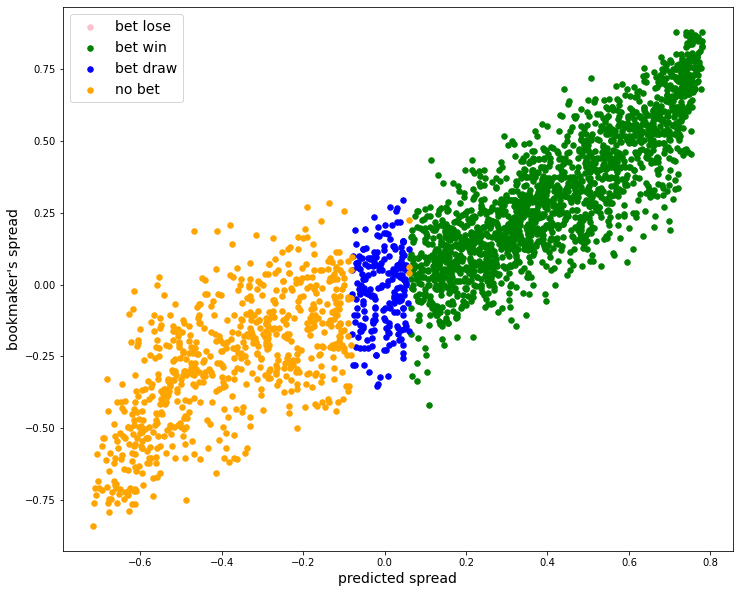

In [19]:
colors1 = {'bet lose':'pink', 'bet win':'green', 'bet draw': 'blue', "no bet":'orange'}

fig, ax = plt.subplots(figsize=(12,10))
for k in colors1.keys():
    #ix = np.where(test_pred_df.loc[test_pred_df["home"]==0,'bet'] == k)[0]
    #ax.scatter(test_pred_df.loc[test_pred_df["home"]==0, "pred_spread"].values[ix],
    #           test_pred_df.loc[test_pred_df["home"]==0, "B365_bookspread"].values[ix],
    #           c = colors1[k], label = k, s = 30)
    
    ix = np.where(test_pred_df['bet'] == k)[0]
    ax.scatter(test_pred_df["pred_spread"].values[ix],
               test_pred_df["B365_bookspread"].values[ix],
               c = colors1[k], label = k, s = 30)
ax.legend(prop={'size': 14})
ax.set_xlabel('predicted spread', fontsize=14)
ax.set_ylabel("bookmaker's spread", fontsize=14)
plt.show()

In [20]:
test_pred_df["bet_accuracy"] = "incorrect"

test_pred_df.loc[((test_pred_df["result"]== 1) & (test_pred_df["bet"]=="bet win") |
                  (test_pred_df["result"]== 0) & (test_pred_df["bet"]=="bet draw")), 
                 "bet_accuracy"] = "correct"

test_pred_df.loc[(test_pred_df["bet"]=="no bet"), "bet_accuracy"] = "no bet"

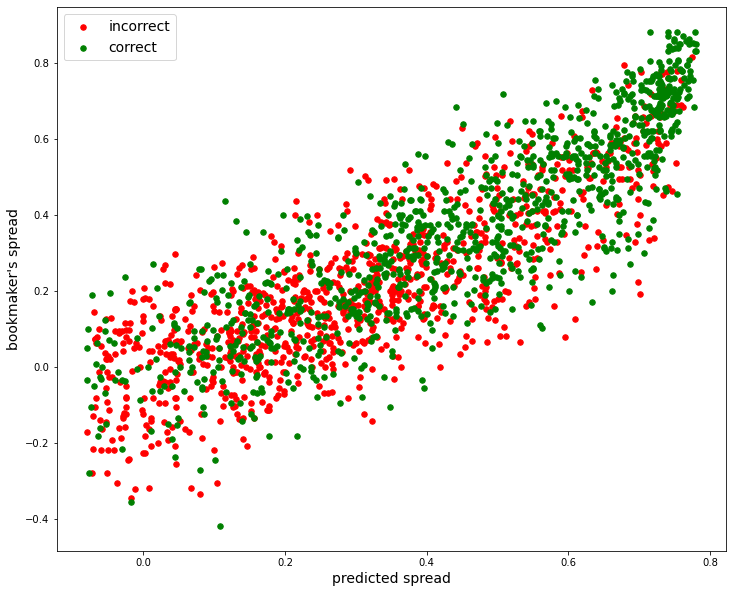

In [21]:
colors2 = {'incorrect':'red', 'correct':'green'}

fig, ax = plt.subplots(figsize=(12,10))
for k in colors2.keys():
    ix = np.where(test_pred_df.loc[test_pred_df["bet_accuracy"]!="no bet",'bet_accuracy'] == k)[0]
    ax.scatter(test_pred_df.loc[test_pred_df["bet_accuracy"]!="no bet","pred_spread"].values[ix],
               test_pred_df.loc[test_pred_df["bet_accuracy"]!="no bet","B365_bookspread"].values[ix],
               c = colors2[k], label = k, s = 30)
ax.legend(prop={'size': 14})
ax.set_xlabel('predicted spread', fontsize=14)
ax.set_ylabel("bookmaker's spread", fontsize=14)
plt.show()

In [22]:
match_df = pd.read_csv(dir + "Data/match_clean.csv")

match_df = match_df.drop('Unnamed: 0',axis=1)

match_df = match_df.loc[match_df["match_id"].isin(set(test_pred_df["match_id"]))]

match_df["result"] = "BWD"
match_df.loc[match_df["home_team_goal"]> match_df["away_team_goal"], "result"] = "BWH"
match_df.loc[match_df["home_team_goal"]< match_df["away_team_goal"], "result"] = "BWA"

In [23]:
bet_lose = test_pred_df.loc[(test_pred_df["pred_spread_bins"].isin(bet_lose_bins)),
                             ["team_id", "match_id", "home", "result"]]

bet_lose["result"].value_counts()

Series([], Name: result, dtype: int64)

In [24]:
bet_lose["result"].value_counts()/len(bet_lose)

Series([], Name: result, dtype: float64)

In [25]:
book_l_df = match_df.loc[match_df["match_id"].isin(set(bet_lose["match_id"])), 
                         ["result", "BWH", "BWD", "BWA", "match_id"]]

book_l_df["pred"] = book_l_df[['BWH','BWD', 'BWA']].idxmin(axis=1)

np.mean(book_l_df["pred"]==book_l_df["result"])

nan

In [26]:
test_pred_df["bet"].value_counts()

bet win     1798
no bet       676
bet draw     213
Name: bet, dtype: int64

In [27]:
test_pred_df["bet_accuracy"].value_counts()

correct      1028
incorrect     983
no bet        676
Name: bet_accuracy, dtype: int64

In [28]:
947/(947+503)

0.6531034482758621

In [29]:
compare_matches = set(test_pred_df.loc[test_pred_df["bet"].isin(["bet lose",
                                                                 "bet win",
                                                                 "bet draw"]), "match_id"])

follow_book_bet = match_df.loc[match_df["match_id"].isin(compare_matches)]

follow_book_bet = follow_book_bet[["match_id", "result", 'BWH','BWD', 'BWA']]

follow_book_bet["pred"] = follow_book_bet[['BWH','BWD', 'BWA']].idxmin(axis=1)

In [30]:
np.mean(follow_book_bet["pred"]==follow_book_bet["result"])

0.5271009448035803

In [31]:
follow_book_bet["dollar"] = follow_book_bet["BWD"]

follow_book_bet["dollar"] = np.where(follow_book_bet["result"]=="BWH", 
                                     follow_book_bet["BWH"],
                                     follow_book_bet["dollar"])


follow_book_bet["dollar"] = np.where(follow_book_bet["result"]=="BWA", 
                                     follow_book_bet["BWA"],
                                     follow_book_bet["dollar"])

follow_book_bet["dollar"] = np.where(follow_book_bet["pred"]!=follow_book_bet["result"],
                                    -1, follow_book_bet["dollar"])



follow_book_bet["dollar"].sum()

949.78

In [47]:
268.5400000000001 + 893.0500000000026

1161.5900000000026

In [48]:
1161.5900000000026-949.78, len(follow_book_bet)

(211.81000000000267, 2011)

In [32]:
np.mean(follow_book_bet["result"]==follow_book_bet["pred"])

0.5271009448035803

In [33]:
test_pred_df["bet_accuracy"].value_counts()

correct      1028
incorrect     983
no bet        676
Name: bet_accuracy, dtype: int64

In [34]:
test_pred_df.columns

Index(['lose_pred', 'win_pred', 'sum_pred', 'league_id', 'season', 'date',
       'stage', 'match_id', 'team_id', 'm_rating', 'win', 'lose',
       'rating_diff', 'home', 'cumulative_win', 'cumulative_lose', 'match_num',
       'match_bin', 'draw', 'avg_overall_rating', 'avg_volleys_imp',
       'avg_long_passing', 'avg_finishing', 'avg_ball_control',
       'avg_dribbling', 'avg_short_passing', 'avg_reactions', 'avg_vision_imp',
       'avg_penalties', 'avg_agility_imp', 'result', 'cumulative_result',
       'B365_bookspread', 'pred_spread', 'pred_spread_bins', 'bet',
       'bet_accuracy'],
      dtype='object')

In [35]:
odds_col = match_df.columns[32:63].tolist()

dollar = 0
for t, m, h, r in zip(bet_lose["team_id"], bet_lose["match_id"], bet_lose["home"], bet_lose["result"]):

    if h == 0:
        bwh = match_df.loc[(match_df["away_team_id"]==t) & 
                           (match_df["match_id"]==m), "BWH"].values[0]
        if np.isnan(bwh):
            continue
            
        if r == -1:
            dollar += bwh
        elif r == 0:
            dollar -= 1
        elif r == 1:
            dollar -= 1
            
    elif h == 1:
        bwa = match_df.loc[(match_df["home_team_id"]==t) & 
                               (match_df["match_id"]==m),  "BWA"].values[0]  
        
        if np.isnan(bwa):
            continue
        
        if r == -1:
            dollar -= 1
        elif r == 0:
            dollar -= 1
        elif r == 1:
            dollar += bwa        

In [36]:
dollar

0

In [37]:
bet_win = test_pred_df.loc[(test_pred_df["pred_spread_bins"].isin(bet_win_bins)), 
                           ["team_id", "match_id", "home", "result"]]

bet_win["result"].value_counts()



 1    971
 0    449
-1    378
Name: result, dtype: int64

In [38]:
book_w_df = match_df.loc[match_df["match_id"].isin(set(bet_win["match_id"])), 
                         ["result", "BWH", "BWD", "BWA", "match_id"]]

book_w_df["pred"] = book_w_df[['BWH','BWD', 'BWA']].idxmin(axis=1)

np.mean(book_w_df["pred"]==book_w_df["result"])

0.5383759733036707

In [39]:
odds_col = match_df.columns[32:63].tolist()

dollar = 0

for t, m, h, r in zip(bet_win["team_id"], bet_win["match_id"], bet_win["home"], bet_win["result"]):
    
    if h == 0:
        bwa = match_df.loc[(match_df["away_team_id"]==t) & 
                           (match_df["match_id"]==m), "BWA"].values[0]
        
        if r == -1:
            dollar -= 1
        elif r == 0:  
            dollar -= 1
        elif r == 1:
            dollar += bwa
        
    elif h == 1:
        bwh = match_df.loc[(match_df["home_team_id"]==t) & 
                           (match_df["match_id"]==m),  "BWH"].values[0]
        
        if r == -1:
            dollar -= 1
        elif r == 0:
            dollar -= 1
        elif r == 1:
            dollar += bwh        

In [40]:
dollar

893.0500000000026

In [41]:
bet_draw = test_pred_df.loc[(test_pred_df["pred_spread_bins"].isin(bet_draw_bins)), 
                           ["team_id", "match_id", "home", "result"]]

bet_draw["result"].value_counts()

-1    80
 1    76
 0    57
Name: result, dtype: int64

In [42]:
book_d_df = match_df.loc[match_df["match_id"].isin(set(bet_draw["match_id"])), 
                         ["result", "BWH", "BWD", "BWA", "match_id"]]

book_d_df["pred"] = book_d_df[['BWH','BWD', 'BWA']].idxmin(axis=1)

np.mean(book_d_df["pred"]==book_d_df["result"])

0.431924882629108

In [45]:
odds_col = match_df.columns[32:63].tolist()

dollar = 0

for t, m, h, r in zip(bet_win["team_id"], bet_win["match_id"], bet_win["home"], bet_win["result"]):
    
    if h == 0:
        bwd = match_df.loc[(match_df["away_team_id"]==t) & 
                           (match_df["match_id"]==m), "BWD"].values[0]
        
        if np.isnan(bwd):
            dollar += 0
        elif r == -1:
            dollar -= 1
        elif r == 0:  
            dollar += bwd
        elif r == 1:
            dollar -= 1
        
    elif h == 1:
        bwd = match_df.loc[(match_df["home_team_id"]==t) & 
                           (match_df["match_id"]==m),  "BWD"].values[0]
        
        if np.isnan(bwd):
            dollar += 0
        elif r == -1:
            dollar -= 1
        elif r == 0:
            dollar += bwd
        elif r == 1:
            dollar -= 1    

In [46]:
dollar

268.5400000000001